In [1]:
%load_ext autoreload
%autoreload 2

### Agent training

In [2]:
import numpy as np
import random as rd
from transformers import AutoImageProcessor
import torch
from torch.utils.data import DataLoader
from stable_baselines3 import PPO, SAC, TD3
from stable_baselines3.common import env_checker


from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.modeling.img_env.img_exploration_env import RewardFunction, ImageExplorationEnv, ImageExplorationEnvConfig
from uav_active_sensing.modeling.mae.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.plots import visualize_tensor, visualize_act_mae_reconstruction
from uav_active_sensing.modeling.agents.rl_agent_feature_extractor import CustomResNetFeatureExtractor
from uav_active_sensing.config import DEVICE, MODELS_DIR

2025-03-13 15:29:12.987 | INFO     | uav_active_sensing.config:<module>:14 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing
2025-03-13 15:29:12.989 | INFO     | uav_active_sensing.config:<module>:36 - Using device: cpu


In [16]:
training_generator = torch.Generator(device=DEVICE).manual_seed(0)

image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
tiny_imagenet_train_dataset = TinyImageNetDataset(split="train", transform=image_processor)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn, generator=training_generator, shuffle=True)

# Pretrained model and reward function
mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
reward_function = RewardFunction(mae_model,
                                 num_samples=1,
                                 patch_size=16,
                                 masking_ratio=0.5,
                                 generator=training_generator,
                                 reward_increase=False)

# Create a dummy environment to initialize the model
dummy_batch = next(iter(tiny_imagenet_train_loader))  # Take one image as a dummy input for env initialization
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function, seed=0)
env = ImageExplorationEnv(env_config)

In [17]:
env.observation_space.sample().shape

(1, 3, 224, 224)

In [18]:
env_checker.check_env(env)

/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


### Test loader deterministic behaviour

In [19]:
image_processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [20]:
# Use in case of multi processing data loading
def worker_init_fn(worker_id): 
    worker_seed = 0 + worker_id
    torch.cuda.manual_seed_all(worker_seed)
    np.random.seed(worker_seed)
    rd.seed(worker_seed)


In [21]:
training_generator = torch.Generator(device=DEVICE).manual_seed(0)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn, generator=training_generator, shuffle=True)

first_run_batches = []
for i, batch in enumerate(tiny_imagenet_train_loader):
  first_run_batches.append(batch)

  if i == 5:
    break

training_generator = torch.Generator(device=DEVICE).manual_seed(0)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn, generator=training_generator, shuffle=True)


second_run_batches = []
for i, batch in enumerate(tiny_imagenet_train_loader):
  second_run_batches.append(batch)

  if i == 5:
    break

for i in range(5):
  print(torch.equal(first_run_batches[i], second_run_batches[i]))


True
True
True
True
True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.552854].


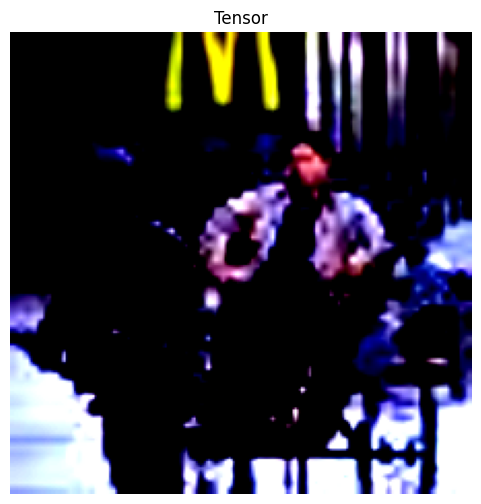

In [22]:
visualize_tensor(first_run_batches[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.552854].


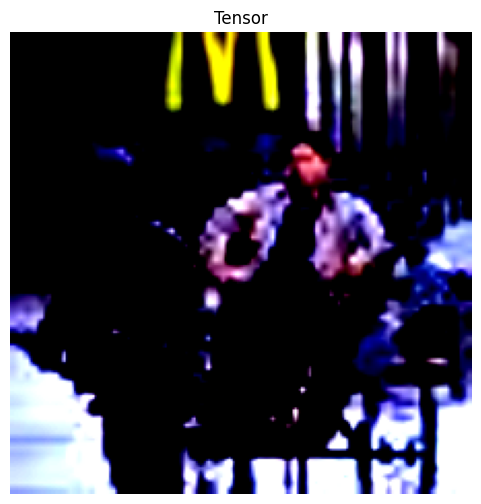

In [23]:
visualize_tensor(second_run_batches[0][0])

### Batch env

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.552854].


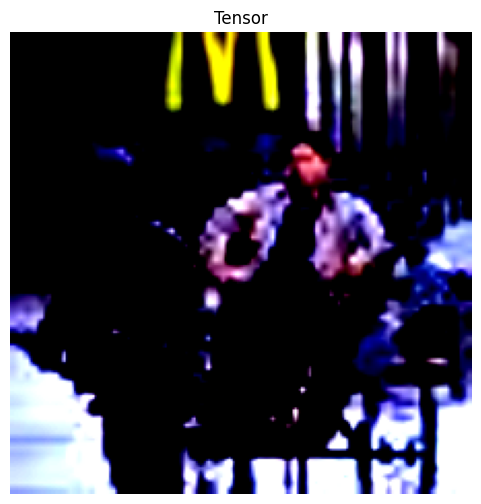

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.3262746].


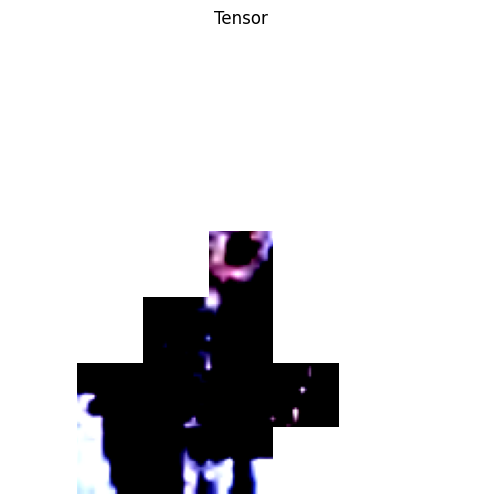

In [24]:
for _ in range(env.max_steps):
    sample_action = env.action_space.sample()
    env.step(sample_action)

for i in range(env.batch_size):
    visualize_tensor(env.img[i])
    visualize_tensor(env.sampled_img[i])

### PPO agent training

In [25]:
rl_num_envs = 1
rl_batch_size = 4
rl_num_steps = rl_batch_size * rl_num_envs * 4

policy_kwargs = dict(
    features_extractor_class=CustomResNetFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=512),
)
env.reset()
resnet_rl_model = PPO(
    "CnnPolicy",
    env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    n_steps=rl_num_steps,
    batch_size=rl_batch_size,
    seed=0
)

for i, batch in enumerate(tiny_imagenet_train_loader):
    vec_env = resnet_rl_model.get_env()
    vec_env.env_method("set_img", batch)
    resnet_rl_model.learn(total_timesteps=4 * rl_num_steps, progress_bar=False)

    if i == 1:
        break

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 4  |
|    iterations      | 1  |
|    time_elapsed    | 3  |
|    total_timesteps | 16 |
---------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 31           |
|    ep_rew_mean          | 2.3          |
| time/                   |              |
|    fps                  | 1            |
|    iterations           | 2            |
|    time_elapsed         | 19           |
|    total_timesteps      | 32           |
| train/                  |              |
|    approx_kl            | 0.0028814673 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.79        |
|    explained_variance   | 3.64e-06     |
|    learning_rate        | 0.0003       |
|    loss             

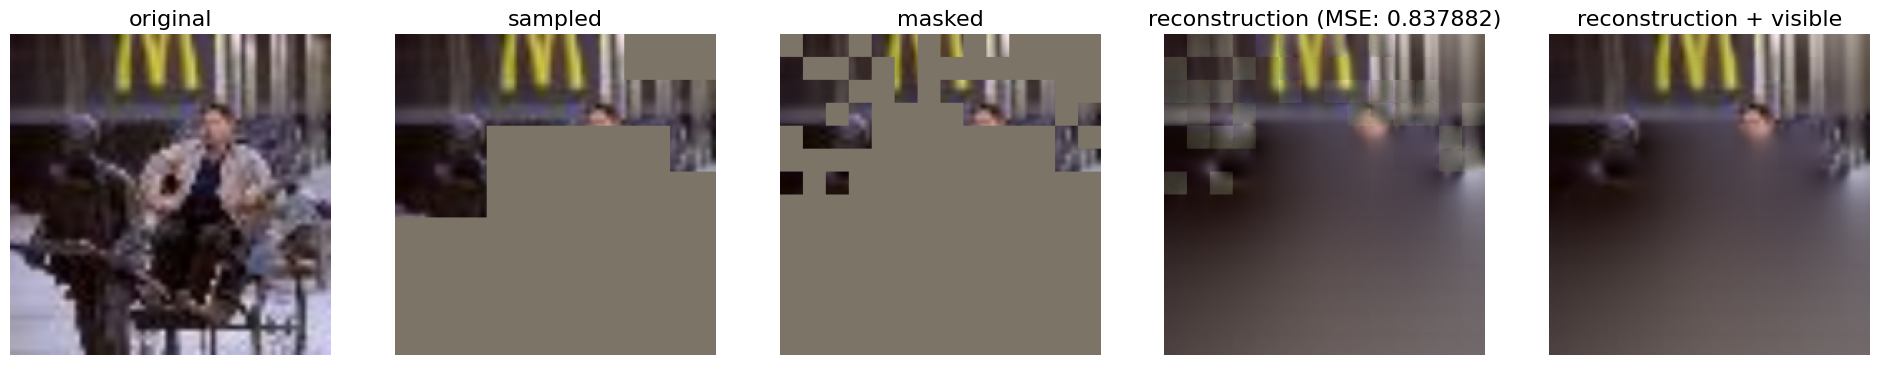

In [41]:
env = ImageExplorationEnv(env_config)
env.reset()
# print(env._sensor_pos)
for _ in range(50):
    sample_action = env.action_space.sample()
    env.step(sample_action)
masked_sampled_img = env._reward_function.sampled_img_random_masking(env.sampled_img)
visualize_act_mae_reconstruction(env.img, env.sampled_img, masked_sampled_img,  mae_model)

In [48]:
env.reset()

tensor([[0., 0.]])


(array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]],
       shape=(1, 3, 224, 224), dtype=float32),
 {})

In [59]:
resnet_rl_model.save(MODELS_DIR / f"resnet_rl_model_seed={0}")

In [13]:
# del resnet_rl_model

In [61]:
resnet_rl_model = PPO.load((MODELS_DIR / f"resnet_rl_model_seed={0}"))

# test_env = ImageExplorationEnv(env_config)
test_env = ImageExplorationEnv(env_config)


# Reset environment and get initial observation
obs, _ = test_env.reset()

# Number of steps to run the evaluation
num_eval_steps = 30

# Disable training mode
resnet_rl_model.policy.eval()

for step in range(num_eval_steps):

    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    action, _ = resnet_rl_model.predict(obs_tensor, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)

    # Print results
    print(f"Step {step + 1}: Action={action}, Reward={reward}")

    # if terminated or truncated:
    #     print("Episode ended, resetting environment.")
    #     obs, _ = test_env.reset()

Step 1: Action=1, Reward=0.5078710913658142
Step 2: Action=1, Reward=0.0
Step 3: Action=1, Reward=0.0
Step 4: Action=1, Reward=0.0
Step 5: Action=1, Reward=0.0
Step 6: Action=1, Reward=0.5419400930404663
Step 7: Action=1, Reward=0.0
Step 8: Action=1, Reward=0.0
Step 9: Action=1, Reward=0.0
Step 10: Action=1, Reward=0.0
Step 11: Action=1, Reward=0.53711998462677
Step 12: Action=1, Reward=0.0
Step 13: Action=1, Reward=0.0
Step 14: Action=1, Reward=0.0
Step 15: Action=1, Reward=0.0
Step 16: Action=1, Reward=0.53711998462677
Step 17: Action=1, Reward=0.0
Step 18: Action=1, Reward=0.0
Step 19: Action=1, Reward=0.0
Step 20: Action=1, Reward=0.0
Step 21: Action=1, Reward=0.53711998462677
Step 22: Action=1, Reward=0.0
Step 23: Action=1, Reward=0.0
Step 24: Action=1, Reward=0.0
Step 25: Action=1, Reward=0.0
Step 26: Action=1, Reward=0.53711998462677
Step 27: Action=1, Reward=0.0
Step 28: Action=1, Reward=0.0
Step 29: Action=1, Reward=0.0
Step 30: Action=1, Reward=0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.552854].


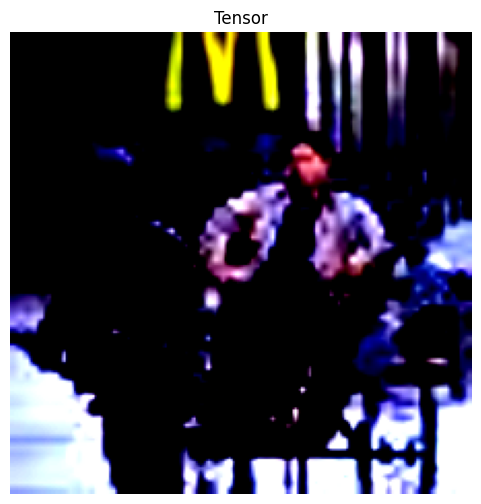

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.018207..0.49620917].


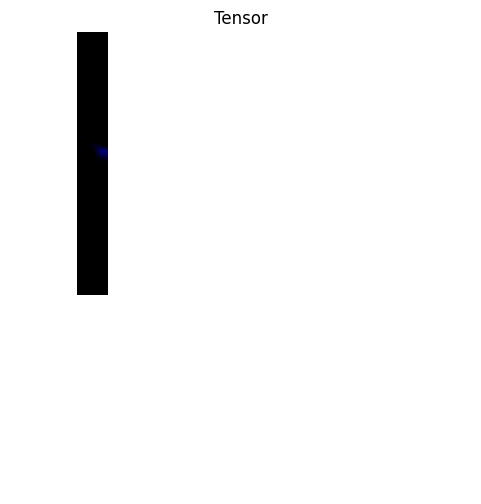

In [62]:
for i in range(test_env.batch_size):
    visualize_tensor(test_env.img[i])
    visualize_tensor(test_env.sampled_img[i])

In [7]:
del resnet_rl_model

NameError: name 'resnet_rl_model' is not defined

In [17]:
resnet_rl_model = PPO.load((MODELS_DIR / "resnet_rl_model"))

test_env = ImageExplorationEnv(env_config)


# Reset environment and get initial observation
obs, _ = test_env.reset()

# Number of steps to run the evaluation
num_eval_steps = 30

# Disable training mode
resnet_rl_model.policy.eval()

for step in range(num_eval_steps):

    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    action, _ = resnet_rl_model.predict(obs_tensor, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)

    # Print results
    print(f"Step {step + 1}: Action={action}, Reward={reward}")

    # if terminated or truncated:
    #     print("Episode ended, resetting environment.")
    #     obs, _ = test_env.reset()

Step 1: Action=[[-0.03586613  0.04027002 -0.05291796]], Reward=0.2781301438808441
Step 2: Action=[[-0.03586795  0.04027075 -0.05291806]], Reward=0.0
Step 3: Action=[[-0.03586819  0.04027089 -0.05291942]], Reward=0.0
Step 4: Action=[[-0.03586914  0.04027038 -0.05291774]], Reward=0.0
Step 5: Action=[[-0.03587116  0.04026977 -0.05291591]], Reward=0.0
Step 6: Action=[[-0.03587161  0.04026836 -0.05291535]], Reward=0.2781301438808441
Step 7: Action=[[-0.0358715   0.04026932 -0.05291726]], Reward=0.0
Step 8: Action=[[-0.03586934  0.04027072 -0.05291487]], Reward=0.0
Step 9: Action=[[-0.03586895  0.04027113 -0.05291753]], Reward=0.0
Step 10: Action=[[-0.03586899  0.04027225 -0.05291666]], Reward=0.0
Step 11: Action=[[-0.03586674  0.04027217 -0.05291623]], Reward=0.2683430016040802
Step 12: Action=[[-0.03586898  0.0402725  -0.0529163 ]], Reward=0.0
Step 13: Action=[[-0.03586659  0.04027249 -0.05291585]], Reward=0.0
Step 14: Action=[[-0.03586786  0.04027218 -0.05291601]], Reward=0.0
Step 15: Act

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].


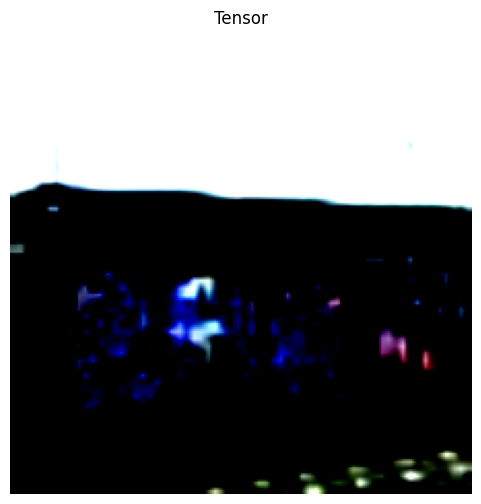

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..0.3567756].


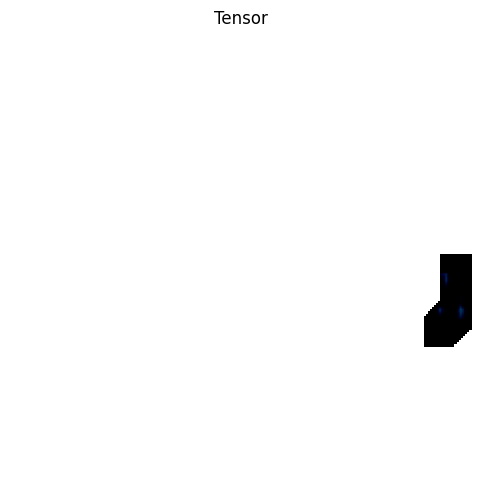

In [18]:
for i in range(test_env.batch_size):
    visualize_tensor(test_env.img[i])
    visualize_tensor(test_env.sampled_img[i])

### SAC agent training

In [26]:
# # For off-policy methods like SAC, we typically use a larger mini-batch size 
# # and do not need to define n_steps (which is for on-policy rollout collection).
# rl_batch_size = 64  # mini-batch size for gradient updates
# rl_timesteps_per_update = 4 * rl_batch_size  # total timesteps to train per iteration

# policy_kwargs = dict(
#     features_extractor_class=CustomResNetFeatureExtractor,
#     features_extractor_kwargs=dict(features_dim=512),
# )

# env.reset()
# sac_model = SAC(
#     "CnnPolicy",
#     env,
#     buffer_size=1000,
#     policy_kwargs=policy_kwargs,
#     verbose=1,
#     batch_size=rl_batch_size,  # used for sampling mini-batches from the replay buffer
#     seed=SEED
# )

# for i, batch in enumerate(tiny_imagenet_train_loader):
#     # Update the environment with new images from the batch.
#     vec_env = sac_model.get_env()
#     vec_env.env_method("set_img", batch)
    
#     # Learn for a fixed number of timesteps.
#     sac_model.learn(total_timesteps=rl_timesteps_per_update, progress_bar=False)

#     # Optional: break after a couple of iterations (for demonstration)
#     if i == 1:
#         break


### TD3 agent training

In [29]:
# rl_batch_size = 4
# rl_timesteps_per_update = 4 * rl_batch_size

# policy_kwargs = dict(
#     features_extractor_class=CustomResNetFeatureExtractor,
#     features_extractor_kwargs=dict(features_dim=512),
# )

# env.reset()
# td3_model = TD3(
#     "CnnPolicy",
#     env,
#     buffer_size=1000,
#     policy_kwargs=policy_kwargs,
#     verbose=1,
#     batch_size=rl_batch_size,
#     seed=SEED
# )

# for i, batch in enumerate(tiny_imagenet_train_loader):
#     vec_env = td3_model.get_env()
#     vec_env.env_method("set_img", batch)
#     td3_model.learn(total_timesteps=rl_timesteps_per_update, progress_bar=False)
#     if i == 1:
#         break


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
